In [2]:
from random import choice
from multiprocessing import Pool
import time
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# Implementation of some of the proposed algorithms in the chapter on 'Multi-armed Bandits'

Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the
difficulties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the q*(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean 0
and standard deviation 0.01 to all the q* (a) on each step). Prepare plots like Figure 2.2
for an action-value method using sample averages, incrementally computed, and another
action-value method using a constant step-size parameter, $\alpha$ = 0.1. Use $\epsilon$ = 0.1 and
longer runs, say of 10,000 steps.

In [3]:
random_walk = norm(0,0.01)
time_steps = 10000
n_iter = 2000
k = 10

In [4]:
def sa_task(k, n_iter, time_steps, random_walk): #sample average
    sa_r=np.zeros(time_steps)
    q = np.ones((k, n_iter))
    Q = np.zeros((k, n_iter))
    eps = 0.1
    for t in range(1, time_steps+1):
        actions = Q.argmax(axis=0)
        epss = np.random.uniform(size=n_iter) < eps
        actions[epss] = np.random.choice(np.arange(k), epss.sum())
        centers = np.take_along_axis(q, actions[None,:], axis=0).flatten()
        rewards = norm(centers, np.ones(n_iter)).rvs()
        Q0 = np.take_along_axis(Q,actions[None,:], axis=0)
        np.put_along_axis(Q, actions[None,:], Q0+1/t*(rewards-Q0), axis=0)
        q += random_walk.rvs(size=(k,n_iter))
        sa_r[t-1] = rewards.mean()
    return sa_r

In [5]:
#sa_r = sa_task(k, n_iter, time_steps, random_walk)

In [6]:
def gb_task(k, n_iter, time_steps, random_walk): #gradient based
    gb_r=np.zeros(time_steps)
    q = np.ones((k, n_iter))
    Q = np.zeros((k, n_iter)) #diventa semplicemente un array di reward medie
    H = np.ones((k, n_iter)) #preferenze per certe azioni
    alpha = 0.5
    for t in range(1, time_steps+1):
        prob=np.exp(H/10)/(np.exp(H/10).sum(axis=0))
        actions = (np.random.uniform(size=(n_iter))<prob.cumsum(axis=0)).argmax(axis=0)
        centers = np.take_along_axis(q, actions[None,:], axis=0).flatten()
        rewards = norm(centers, np.ones(n_iter)).rvs()
        H0 = np.take_along_axis(H,actions[None,:], axis=0)
        Q0 = np.take_along_axis(Q,actions[None,:], axis=0)
        P0 = np.take_along_axis(prob,actions[None,:], axis=0)
        np.put_along_axis(Q, actions[None,:], Q0+1/t*(rewards-Q0), axis=0)
        H-=alpha*(rewards-Q0)*P0
        np.put_along_axis(H, actions[None,:], H0+alpha*(rewards-Q0)*(1-P0)+alpha*(rewards-Q0)*P0, axis=0)
        q += random_walk.rvs(size=(k,n_iter))
        gb_r[t-1] = rewards.mean()
    return gb_r

In [7]:
def cs_task(k, n_iter, time_steps, random_walk): #constant step
    cs_r=np.zeros(time_steps)
    q = np.ones((k, n_iter))
    Q = np.zeros((k, n_iter))
    eps = 0.1
    alpha = 0.1
    for t in range(1, time_steps+1):
        actions = Q.argmax(axis=0)
        epss = np.random.uniform(size=n_iter) < eps
        actions[epss] = np.random.choice(np.arange(k), epss.sum())
        centers = np.take_along_axis(q, actions[None,:], axis=0).flatten()
        rewards = norm(centers, np.ones(n_iter)).rvs()
        Q0 = np.take_along_axis(Q,actions[None,:], axis=0)
        np.put_along_axis(Q, actions[None,:], Q0+alpha*(rewards-Q0), axis=0)
        q += random_walk.rvs(size=(k,n_iter))
        cs_r[t-1] = rewards.mean()
    return cs_r

In [8]:
#cs_r = cs_task(k, n_iter, time_steps, random_walk)

In [9]:
n_processes = 5
n_iter_per_process = n_iter//n_processes
with Pool() as p:
    start = time.perf_counter()
    res_sa = p.starmap_async(sa_task, [(k, n_iter_per_process, time_steps, random_walk) for i in range(n_processes)])
    res_cs = p.starmap_async(cs_task, [(k, n_iter_per_process, time_steps, random_walk) for i in range(n_processes)])
    res_gb = p.starmap_async(gb_task, [(k, n_iter_per_process, time_steps, random_walk) for i in range(n_processes)])
    sa_r = np.array(res_sa.get()).mean(axis=0)
    cs_r = np.array(res_cs.get()).mean(axis=0)
    gb_r = np.array(res_gb.get()).mean(axis=0)
    end = time.perf_counter()
    print(end-start)

83.85428234400024


As shown in the figure, the method based on sample average struggle to follow the changes in the q* (a) compared to the other methods. The random walk cause some of the k action to give higher rewards and the constant step method was able to better exploit this, thus obtaining higher rewards over thime.

<Axes: title={'center': 'Average rewards of 2k iterations over 10k timesteps'}>

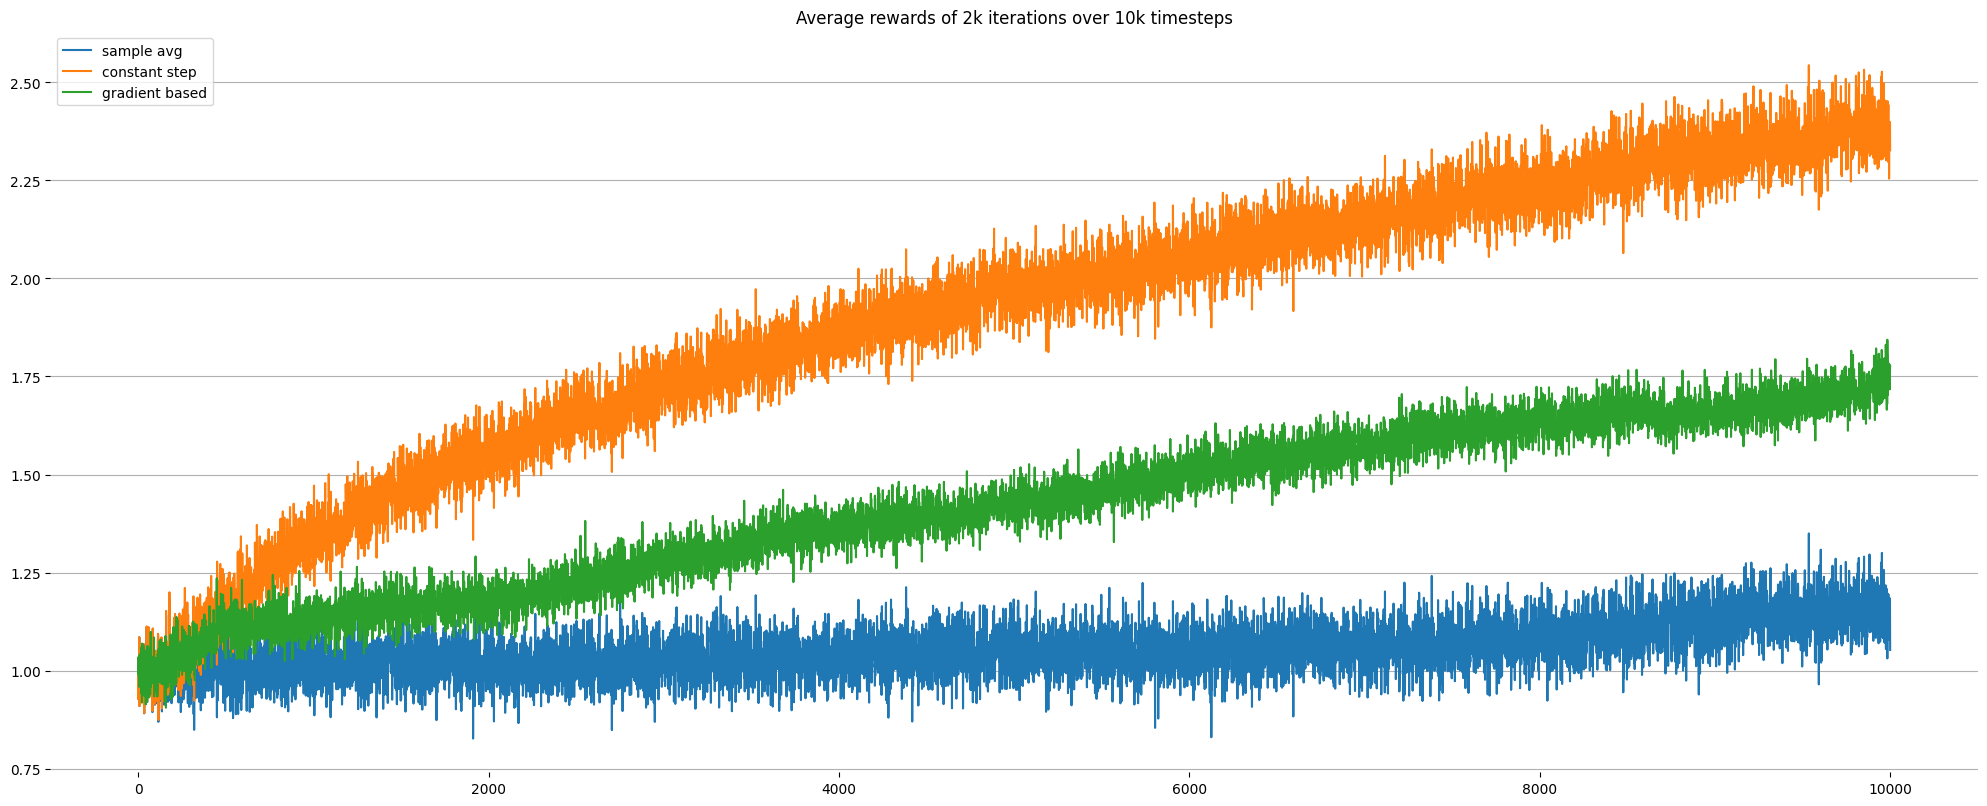

In [10]:
fig, (ax1) = plt.subplots(nrows=1, ncols = 1, figsize = (20,8))
fig.tight_layout(h_pad = 6)
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_title("Average rewards of 2k iterations over 10k timesteps")
window = np.ones(1)
sns.lineplot(np.convolve(sa_r, window, mode='valid'), ax=ax1, label='sample avg')
sns.lineplot(np.convolve(cs_r, window, mode='valid'), ax=ax1, label='constant step')
sns.lineplot(np.convolve(gb_r, window, mode='valid'), ax=ax1, label='gradient based')